In [1]:
from polycasebuilder import generate_random_polynomials, get_arg_mapping, directed_poly_executables, eqv_to_edges_tree
from testproblems import generate_random_prob
from graphutils import VAR, COMP, SOLVER, edges_to_Ein_Eout, sinks, sources, namefromid, all_components, nested_sources, path
from workflow import OBJ, NEQ, EQ, OPT
from runpipeline import nestedform_to_mdao
import numpy as np
from execution import Component
from operators import sort_scc, reorder_merge_solve
from representations import bipartite_repr
from inputresolver import getallvars, direct_eqs, invert_edges
from tearing import min_max_scc, outset_from_solution
from compute import Var
import openmdao.api as om
import pandas as pd
from functools import partial
from collections import defaultdict

In [2]:
from numpy import random

In [3]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{}', SOLVER: 's_{}'}
namefunc = namefromid(nodetyperepr)

In [4]:
def generate_var(varids):
    return [Var(namefunc(varid, VAR)) for varid in varids]

In [5]:
#(5,10,7,1.7 no numerical issues)
n_eqs = 5
n_vars = 10
seed = 9#8 is triang#seed 10 is nice 42 
sparsity = 1.7#0.8 1.1 #1.7 1.3
eqv, varinc, output_set = generate_random_prob(n_eqs, n_vars, seed, sparsity)
#polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, output_set, n_eqs)

In [6]:
eqv

{0: (5, 6, 7, 10, 11, 12),
 1: (6, 7, 9, 11, 12, 13, 5),
 2: (5, 6, 8, 9, 10, 11, 12),
 3: (6, 8, 11, 12, 14),
 4: (5, 6, 8, 10, 11, 12, 13, 14, 7)}

In [7]:
def optimal_formulation(eqv, output_set):
    n_eqs = len(eqv)
    _, edges_original = bipartite_repr(eqv)
    eqs=direct_eqs(eqv, output_set)
    avrs = getallvars(eqs, sympy=False)
    eqns = eqs.keys()
    graph_edges = invert_edges(edges_original)
    maxl, m = min_max_scc(graph_edges, avrs, eqns, len(eqns))
    best_outset = dict(outset_from_solution(m))
    return best_outset

In [8]:
def generate(g, limit=2):
    def generator(*args):
        for i in range(limit):
            for elt in g(*args):
                yield elt
    return generator

In [9]:
rng1 = np.random.default_rng(0);
rng2 = np.random.default_rng(1);

In [10]:
def g1(m,n,c,eqvs=None,outsets=None,randstruct=None):
    s = int(rng1.integers(0, 2**16))
    randstruct[(m,n,c)].append(s)
    eqv, _, output_set = generate_random_prob(m, n, s, c)
    output_set_opt = optimal_formulation(eqv, output_set)
    eqvs[(m,n,c,s)] = eqv
    outsets[(m,n,c,s,1)] = output_set
    outsets[(m,n,c,s,2)] = output_set_opt
    yield (m, n, c, s)

In [11]:
def g2(m, n, c, s, randpoly=None):
    r = int(rng2.integers(0, 2**31))
    randpoly[(m,n,c,s)].append(r)
    yield (m, n, c, s, 1, r)
    yield (m, n, c, s, 2, r)

In [12]:
def g3(*args):
    yield tuple(args) + (True,)
    yield tuple(args) + (False,)

In [13]:
outsets = dict()
eqvs = dict()
randstruct = defaultdict(list)
randpoly = defaultdict(list)

In [14]:
funtable = {
    1: (generate(partial(g1, eqvs=eqvs,outsets=outsets, randstruct=randstruct), limit=10), 2),
    2: (generate(partial(g2, randpoly=randpoly), limit=10), 3),
    3: (g3, None)
}

In [15]:
q = [(1, (10, 15, 1))]
output = []
while q:
    fid, args = q.pop()
    if fid:
        f, nextfid  = funtable[fid]
        for elt in f(*args):
            q.append((nextfid,elt))
    else:
        output.append(args)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [16]:
def add_obj(inputids, var_mapping, edges, tree, components):
    inputvars = [var_mapping[elt][0] for elt in inputids]
    fobj = sum([(elt-1)**2 for elt in inputvars])
    newidx = 'obj'
    c = Component.fromsympy(fobj, component=newidx)
    edges[0][newidx] = c.inputs
    edges[1][newidx] = c.outputs
    tree[0][newidx] = 1
    return components+[c], newidx

In [17]:
def generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf=True):
    components, newidx = add_obj(inputids, var_mapping, edges, tree, components)
    solvers_options = {1: {'type': OPT, 'disp':False}, 2:{'maxiter':200}}
    comp_options = {newidx:OBJ}
    dv = nested_sources(edges, tree, 1)
    for elt in dv:
        tree[2][elt] = 1
    var_options = {}
    nodetyperepr = {VAR: 'x{}', COMP: 'f_{}', SOLVER: 's_{}'}
    prob, mdao_in, groups, formulation,merge_order = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf)
    return prob, groups, formulation, merge_order

In [40]:
def get_mdaoprobargs(outsets, eqvs, m, n, c, r1, M, r2, mdf):
    outset = outsets[(m,n,c,r1,M)]
    eqv = eqvs[(m,n,c,r1)]
    n_eqs = len(eqv)
    rng = np.random.default_rng(r2)
    _, var_mapping, edges, tree, components = generate_random_polynomials(eqv, outset, n_eqs, rng)
    inputids = sources(*edges_to_Ein_Eout(edges))
    return inputids, var_mapping, edges, tree, components

In [41]:
def generate_prob(outsets, eqvs, m, n, c, r1, M, r2, mdf):
    inputids, var_mapping, edges, tree, components = get_mdaoprobargs(outsets, eqvs, m, n, c, r1, M, r2, mdf)
    prob, groups, formulation,merge_order = generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf)
    scc = [len(elt) for elt in merge_order if len(elt)>1]
    try:
        prob.set_solver_print(-1)
        prob.run_driver()
        Stree=formulation[1][1]
        total_iters = 0
        for key,var in Stree.items():
            parent = groups['s_{}'.format(var)]
            total_iters += getattr(parent, 's_{}'.format(key)).iter_count_apply
        return prob.driver.result.fun, total_iters, scc
    except:
        return 9999, True, scc

In [19]:
df = pd.DataFrame(output)
df.set_axis(['m', 'n', 'c', 'r1', 'M', 'r2', 'mdf'], axis=1, inplace=True)

In [39]:
# for idx,elt in enumerate(df.iloc):
#     if idx <= 1000:
#         kwargs = {key:var for key,var in elt.items() if key not in ['fobj', 'niter', 'scc']}
#         fobj, niter, scc = generate_prob(outsets, eqvs, **kwargs)
#         df.loc[idx, 'fobj'] = np.round(fobj,2)
#         df.loc[idx, 'niter'] = niter
#         df.loc[idx, 'scc'] = str(scc)

In [31]:
sum(df[(df["M"]==1) & (df["r1"]==53298) & (df["mdf"]==True)]['niter']>=0.1)

10

In [34]:
randstruct

defaultdict(list,
            {(10, 15, 1): [55746,
              41743,
              33497,
              17680,
              20173,
              2685,
              4930,
              1083,
              11486,
              53298]})

In [61]:
df[(df["M"]==2) & (df["r1"]==20173)& (df["mdf"]==True)]

,m,n,c,r1,M,r2,mdf,fobj,niter,scc
201,10,15,1,20173,2,2082898964,True,0.0,15,[2]
205,10,15,1,20173,2,692725761,True,0.0,21,[2]
209,10,15,1,20173,2,344997561,True,9999.0,True,[2]
213,10,15,1,20173,2,1558804748,True,0.0,804,[2]
217,10,15,1,20173,2,594619332,True,0.0,7,[2]
221,10,15,1,20173,2,1986274268,True,0.0,725,[2]
225,10,15,1,20173,2,1162275822,True,0.0,804,[2]
229,10,15,1,20173,2,629526661,True,0.0,475,[2]
233,10,15,1,20173,2,1556474546,True,0.0,15,[2]
237,10,15,1,20173,2,197792239,True,0.0,217,[2]


In [50]:
df

,m,n,c,r1,M,r2,mdf,fobj,niter,scc
0,10,15,1,53298,2,669652944,False,0.0,0.0,[2]
1,10,15,1,53298,2,669652944,True,0.0,804.0,[2]
2,10,15,1,53298,1,669652944,False,0.0,0.0,[6]
3,10,15,1,53298,1,669652944,True,9999.0,True,[6]
4,10,15,1,53298,2,535214420,False,0.0,0,[2]
...,...,...,...,...,...,...,...,...,...,...
395,10,15,1,55746,1,1094134074,True,0.0,264,[9]
396,10,15,1,55746,2,1248920238,False,0.0,0,[]
397,10,15,1,55746,2,1248920238,True,0.0,0,[]
398,10,15,1,55746,1,1248920238,False,0.0,0,[9]


In [44]:
elt = df.iloc[10]
kwargs = {key:var for key,var in elt.items() if key not in ['fobj', 'niter', 'scc']}
inputids, var_mapping, edges, tree, components = get_mdaoprobargs(outsets, eqvs, **kwargs)

In [45]:
components

[((11, 0), 0, (None,), '-0.1*x_0*x_11 + 0.3'),
 ((3, 14, 8, 5, 10), 1, (None,), '-0.6*x_10*x_3*x_5 - 0.4*x_14*x_8 - 0.4'),
 ((2, 6), 2, (None,), '-0.9*x_2*x_6 + 0.2'),
 ((11, 13, 4, 12), 3, (None,), '-0.2*x_11*x_13 - 0.5*x_12*x_4 - 0.3'),
 ((11, 0, 12), 4, (None,), '0.3*x_0*x_11*x_12 + 0.8'),
 ((11, 7, 8, 13), 5, (None,), '0.7*x_11*x_13*x_8 - 0.1*x_7 - 0.2'),
 ((3, 4), 6, (None,), '-0.4*x_3*x_4 - 0.9'),
 ((0, 4, 7, 8, 10), 7, (None,), '0.4*x_0*x_10*x_8 - 0.2*x_4*x_7 + 0.8'),
 ((7, 9), 8, (None,), '0.9*x_7*x_9 - 0.9'),
 ((11, 0, 4, 12), 9, (None,), '-0.5*x_0*x_12 + 0.3*x_11*x_4 - 0.6'),
 ((0,), 0, (11,), '3.0/x_0'),
 ((3, 8, 5, 10), 1, (14,), '-(1.5*x_10*x_3*x_5 + 1.0)/x_8'),
 ((2,), 2, (6,), '0.222222222222222/x_2'),
 ((11, 4, 12), 3, (13,), '-(2.5*x_12*x_4 + 1.5)/x_11'),
 ((11, 12), 4, (0,), '-2.66666666666667/(x_11*x_12)'),
 ((11, 8, 13), 5, (7,), '7.0*x_11*x_13*x_8 - 2.0'),
 ((4,), 6, (3,), '-2.25/x_4'),
 ((7, 8, 10, 0), 7, (4,), '(2.0*x_0*x_10*x_8 + 4.0)/x_7'),
 ((7,), 8, (9,), '1/

In [95]:
inputids, var_mapping, edges, tree, components = generate_prob(outsets, eqvs, **df.iloc[10])
prob,formulation = generate_mdao_prob(inputids, var_mapping, edges, tree, components)

In [96]:
formulation[1]

(OrderedDict([(3, 2), (1, 2), ('obj', 1), (0, 1), (2, 1), (4, 1)]),
 {2: 1},
 {8: 1, 1: 1, 3: 1, 6: 1, 7: 2, 5: 2})

In [97]:
#prob.set_solver_print(-1)

In [98]:
prob.run_driver();


s_1.s_2
NL: Newton Converged in 7 iterations

s_1.s_2
NL: Newton Converged in 1 iterations

s_1.s_2
NL: Newton Converged in 5 iterations

s_1.s_2
NL: Newton Converged in 4 iterations


In [99]:
#prob.model.s_1.s_2.iter_count_apply

In [100]:
prob.driver.result.fun

array([0.])

In [212]:
components, newidx = add_obj(inputids, var_mapping, edges, tree, components)
solvers_options = {1: {'type': OPT}, 2:{'maxiter':100}}
comp_options = {newidx:OBJ}
var_options = {}
nodetyperepr = {VAR: 'x{}', COMP: 'f_{}', SOLVER: 's_{}'}
#prob, mdao_in, groups = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf=True)

In [171]:
components

[((1, 5, 0, 6, 2), 0, (None,), '0.4*x_0*x_2*x_6 - 0.5*x_1*x_5 + 0.1'),
 ((8, 5), 1, (None,), '0.6*x_5*x_8 + 0.5'),
 ((8, 6, 5, 0), 2, (None,), '0.3*x_0*x_6 + 0.8*x_5*x_8 - 0.2'),
 ((6, 4), 3, (None,), '-0.2*x_4*x_6 - 0.3'),
 ((1, 2), 4, (None,), '1.0*x_1*x_2 + 0.4'),
 ((5, 1, 2, 0), 0, (6,), '(1.25*x_1*x_5 - 0.25)/(x_0*x_2)'),
 ((5,), 1, (8,), '-0.833333333333333/x_5'),
 ((8, 6, 5), 2, (0,), '(-2.66666666666667*x_5*x_8 + 0.666666666666667)/x_6'),
 ((6,), 3, (4,), '-1.5/x_6'),
 ((1,), 4, (2,), '-0.4/x_1'),
 ((1, 5), 'obj', (None,), '(x_1 - 1)**2 + (x_5 - 1)**2')]

In [57]:
eqv = eqvs[(5,10,1,5546)]

In [58]:
eqv

{0: (6, 12, 13, 7), 1: (6, 10, 8), 2: (9, 13, 14, 5), 3: (6, 9, 13), 4: (12,)}

In [59]:
outset = outsets[(5,10,1,5546,2)]

In [60]:
outset

{0: 2, 1: 3, 2: 0, 3: 8, 4: 7}

In [56]:
args=df.iloc[0:2]
args

,m,n,c,r1,M,r2,mdf
0,5,10,1,5546,2,74845286,False
1,5,10,1,5546,2,74845286,True


# -----

In [ ]:
def run_incidence_case(eqv, output_set, n_eqs, inputids):
    polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, output_set, n_eqs)
    optimal_formulation(eqv, output_set)
    generate_mdao_prob(inputids, var_mapping, edges, tree, components):

In [143]:
_, edges_original = bipartite_repr(eqv)
eqs=direct_eqs(eqv, output_set)
avrs = getallvars(eqs, sympy=False)
eqns = eqs.keys()
graph_edges = invert_edges(edges_original)

In [144]:
maxl, m = min_max_scc(graph_edges, avrs, eqns, len(eqns))

In [145]:
maxl

3.0

In [146]:
output_set2 = dict(outset_from_solution(m))

In [147]:
output_set2 = {key:var-n_eqs for key,var in output_set2.items()}

In [148]:
components2 = directed_poly_executables(var_mapping, polynomials, output_set2)

In [149]:
edges2, tree2 = eqv_to_edges_tree(eqv, output_set2, n_eqs)

In [150]:
sources(*edges_to_Ein_Eout(edges2))

{0, 1, 6, 8, 9}

In [151]:
inputids = sources(*edges_to_Ein_Eout(edges2))

In [153]:
components1 = add_obj(inputids, var_mapping, edges, tree, components)

In [154]:
dv = nested_sources(edges, tree, 1)
for elt in dv:
    tree[2][elt] = 1

In [155]:
components22 = add_obj(inputids, var_mapping, edges2, tree2, components2)

In [156]:
dv = nested_sources(edges2, tree2, 1)
for elt in dv:
    tree2[2][elt] = 1

In [157]:
dv

{0, 1, 6, 8, 9}

In [158]:
# from graphutils import flat_graph_formulation, root_solver
# from operators import sort_scc, reorder_merge_solve
# from workflow import order_from_tree, mdao_workflow, default_solver_options
# G = flat_graph_formulation(*edges)
# merge_order = sort_scc(G)
# merge_parent = root_solver(tree) # all merged components will have this solver as the parent
# ordered_edges, ordered_tree = reorder_merge_solve(edges, tree, merge_order, merge_parent, False)
# sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
# solvers_options = default_solver_options(ordered_tree, solvers_options)
# wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [159]:
solvers_options = {1: {'type': OPT}, 2:{'maxiter':100}}
comp_options = {newidx:OBJ}
var_options = {}

In [164]:
nodetyperepr = {VAR: 'x{}', COMP: 'f_{}', SOLVER: 's_{}'}
prob, mdao_in, groups = nestedform_to_mdao(edges2, tree2, components22, solvers_options, comp_options, var_options, nodetyperepr, mdf=True)

In [165]:
om.n2(prob.model)

In [166]:
for elt in mdao_in:
    prob.set_val(elt, 0.1)

In [167]:
prob.run_driver();


s_1.s_2
NL: Newton Converged in 1 iterations

s_1.s_2
NL: Newton Converged in 0 iterations

s_1.s_2
NL: Newton Converged in 1 iterations

s_1.s_2
NL: Newton Converged in 1 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [0.]
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


In [27]:
prob.model.list_outputs();

11 Explicit Output(s) in 'model'

varname   val          
--------  -------------
inp
  x3      [1.]         
  x5      [1.]         
  x6      [1.]         
  x7      [1.]         
  x9      [1.]         
s_1
  f_2
    x2    [-0.33333333]
  f_5
    obj5  [0.]         
  f_1
    x4    [-1.66666667]
  f_3
    x0    [1.26666667] 
  f_0
    x8    [-0.24444444]
  f_4
    x1    [7.07792208] 


0 Implicit Output(s) in 'model'




In [39]:
merge_order

[{f_0}, {f_3}, {f_1}, {f_2, f_4}]

In [42]:
sources(*edges_to_Ein_Eout(edges))

{1, 4, 5, 6}

In [10]:
output_set2

{0: 9, 1: 6, 2: 10, 3: 13, 4: 12}

In [27]:
maxl

2.0

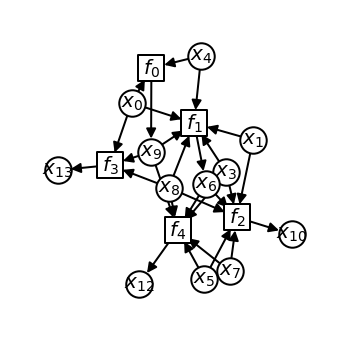

In [26]:
from graphutils import flat_graph_formulation, draw_graph_graphical_props
G = flat_graph_formulation(*edges2, nodetyperepr=default_nodetyperepr)
draw_graph_graphical_props(G, {}, prog='neato', figsize=(6,6))

In [16]:
polynomials

{0: 0.6*x_1*x_3*x_4 + 0.4,
 1: -0.5*x_0 + 0.9*x_1*x_3 + 0.3*x_2*x_4 + 0.9,
 2: 0.4*x_0*x_2 - 0.3*x_1*x_3*x_4 + 0.5}

In [11]:
output_set = {key:var-n_eqs for key,var in output_set.items()}
edges, tree= eqv_to_edges_tree(eqv, output_set, n_eqs)

In [12]:
rng = np.random.default_rng(12345)

In [13]:
nodetyperepr = {VAR: '{}', COMP: 'f_{}', SOLVER: 's_{}'}
solvers_options = {1: {'type': OPT}}
comp_options = {3:OBJ, 4:NEQ, 5:NEQ}
var_options = {}

In [ ]:
prob, mdao_in, groups = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf=True)